<a href="https://colab.research.google.com/github/dianamory/dianamory.github.io/blob/main/Store_Sales_Analysis_SQL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**PROBLEMA DE NEGOCIO**


---




### Una tienda online de moda, con presencia en todo Brasil, necesita impulsar su rendimiento utilizando sus datos de manera estratégica. Como científico de datos, has sido convocado para analizar estos datos y ofrecer insights que guíen sus decisiones y respondan a las siguientes preguntas clave:

### **Preguntas**

1. ¿Cual es el Top 5 productos más vendidos históricamente?

2. ¿Cual es la evolución histórica de las ingresos netos?

3. ¿Cuáles son los ingresos netos por vendedor por año?

4. ¿Cuáles son las ciudades que proporcionan mayores ingresos netos?

5. ¿Existe otro insight que puedas proporcionar?


# 1. Configuración del Ambiente

In [ ]:
!pip install geobr
import geobr
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import FancyBboxPatch
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as ticker
import requests
from io import BytesIO
from sqlalchemy import create_engine, MetaData, Table, inspect, text
global df_itens_pedidos, df_pedidos, df_productos, df_vendedores, database

In [ ]:
!python -V
print('------')
!pip show Pandas | grep 'Name\|Version'
print('------')
!pip show Matplotlib | grep 'Name\|Version'

Python 3.10.12
------
Name: pandas
Version: 2.0.3
------
Name: matplotlib
Version: 3.7.1


# 2. Obtención de datos EDA

In [ ]:
#cargamos las bases de datos
df_itens_pedidos = pd.read_csv('https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/itens_pedidos.csv')
df_itens_pedidos.head(5)

,id_recibo,producto_id,pedido_id,cantidad,valor_unitario,valor_total,ciudad,costo_envio
0,1,41518,341,3,260,780,BR-BA,156.0
1,2,4307,1174,5,6175,30875,BR-RJ,6175.0
2,3,22407,1399,3,200,600,BR-PB,120.0
3,4,3820,1652,6,139,834,BR-DF,166.8
4,5,29012,2470,3,525,1575,BR-BA,315.0


In [ ]:
df_pedidos = pd.read_csv('https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/pedidos.csv')
df_pedidos.head(5)

,pedido_id,producto_id,vendedor_id,fecha_compra,total
0,341,41518,6,2019-01-05,780
1,1174,4307,3,2019-01-05,30875
2,1399,22407,1,2019-01-05,600
3,1652,3820,4,2019-01-05,834
4,2470,29012,2,2019-01-05,1575


In [ ]:
df_productos = pd.read_csv('https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/productos.csv')
df_productos.head(5)

,producto_id,producto,precio,marca,sku,condicion
0,21244,Oculos Lente Azulada,1120,D&g Dolce & Gabbana,209297.0,Usado
1,9981,Bolsa Coral Saco,4000,Givenchy,278612.0,Usado
2,84176,Camisa Xadrez Verde,310,Joe Fresh,322482.0,Usado
3,47475,Calca Alfaiataria Preta,490,Mixed,263658.0,Usado
4,74864,Vestido Jeans Babados,130,Zara,219248.0,Usado


In [ ]:
df_vendedores = pd.read_csv('https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/vendedores.csv')
df_vendedores.head(5)

,vendedor_id,nombre_vendedor
0,1,Ana Duarte
1,2,Daniel Siqueira
2,3,Nadia Oliveira
3,4,Millena Pereira
4,5,Paulo Calanca


# 3.Tratamiento de datos

In [ ]:
print(df_itens_pedidos.info())
print('-------------')
print(df_pedidos.info())
print('-------------')
print(df_productos.info())
print('-------------')
print(df_vendedores.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24527 entries, 0 to 24526
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id_recibo       24527 non-null  int64  
 1   producto_id     24527 non-null  int64  
 2   pedido_id       24527 non-null  int64  
 3   cantidad        24527 non-null  int64  
 4   valor_unitario  24527 non-null  int64  
 5   valor_total     24527 non-null  int64  
 6   ciudad          24527 non-null  object 
 7   costo_envio     24527 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 1.5+ MB
None
-------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24527 entries, 0 to 24526
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   pedido_id     24527 non-null  int64 
 1   producto_id   24527 non-null  int64 
 2   vendedor_id   24527 non-null  int64 
 3   fecha_compra  24527 non-null  object
 

In [ ]:
# Identificar registros con valores nulos
registros_nulos = df_productos[df_productos.isna().any(axis=1)]

# Mostrar los registros con valores nulos
print(registros_nulos)

     producto_id producto  precio                marca  sku  \
205        41598      NaN     260      Banana Republic  NaN   
206        32926      NaN     210  Limone By Jade Seba  NaN   

              condicion  
205  Nuevo con etiqueta  
206  Nuevo sin etiqueta  


In [ ]:
def preprocesamiento():
  global df_itens_pedidos, df_pedidos, df_productos, df_vendedores, database

  #elimino nulos en este caso solo el df_productos tiene nulos
  df_productos = df_productos.dropna(subset=['producto'])

  #eliminamos duplicados
  df_itens_pedidos = df_itens_pedidos.drop_duplicates()
  df_pedidos = df_pedidos.drop_duplicates()
  df_productos = df_productos.drop_duplicates()
  df_vendedores = df_vendedores.drop_duplicates()

  #modificamos tipo de dato de fechas
  df_pedidos['fecha_compra'] = pd.to_datetime(df_pedidos['fecha_compra'],format='%Y-%m-%d')

  return df_itens_pedidos, df_pedidos, df_productos, df_vendedores

preprocesamiento()

(       id_recibo  producto_id  pedido_id  cantidad  valor_unitario  \
 0              1        41518        341         3             260   
 1              2         4307       1174         5            6175   
 2              3        22407       1399         3             200   
 3              4         3820       1652         6             139   
 4              5        29012       2470         3             525   
 ...          ...          ...        ...       ...             ...   
 24522      25051        64127      63716         4             590   
 24523      25052        37384      63999         4             700   
 24524      25053       100932      64594         5            3900   
 24525      25054         3820      64811         3             139   
 24526      25055        74864      65274         2             130   
 
        valor_total ciudad  costo_envio  
 0              780  BR-BA        156.0  
 1            30875  BR-RJ       6175.0  
 2              600 

In [ ]:
print(df_itens_pedidos.info())
print('-------------')
print(df_pedidos.info())
print('-------------')
print(df_productos.info())
print('-------------')
print(df_vendedores.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24527 entries, 0 to 24526
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id_recibo       24527 non-null  int64  
 1   producto_id     24527 non-null  int64  
 2   pedido_id       24527 non-null  int64  
 3   cantidad        24527 non-null  int64  
 4   valor_unitario  24527 non-null  int64  
 5   valor_total     24527 non-null  int64  
 6   ciudad          24527 non-null  object 
 7   costo_envio     24527 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 1.5+ MB
None
-------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24527 entries, 0 to 24526
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   pedido_id     24527 non-null  int64         
 1   producto_id   24527 non-null  int64         
 2   vendedor_id   24527 non-null  int64         
 3 

# EDA

In [ ]:
df_itens_pedidos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24527 entries, 0 to 24526
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id_recibo       24527 non-null  int64  
 1   producto_id     24527 non-null  int64  
 2   pedido_id       24527 non-null  int64  
 3   cantidad        24527 non-null  int64  
 4   valor_unitario  24527 non-null  int64  
 5   valor_total     24527 non-null  int64  
 6   ciudad          24527 non-null  object 
 7   costo_envio     24527 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 1.5+ MB


In [ ]:
df_itens_pedidos.describe()

,id_recibo,producto_id,pedido_id,cantidad,valor_unitario,valor_total,costo_envio
count,24527.000000,24527.000000,24527.000000,24527.000000,24527.00000,24527.000000,24527.000000
mean,12405.414278,44627.641171,69931.383088,3.497126,535.68867,1867.490113,373.498023
std,7242.697484,29347.824879,40560.769565,1.706170,839.21405,3379.681887,675.936377
min,1.000000,2706.000000,1.000000,1.000000,45.00000,45.000000,9.000000
25%,6132.500000,17258.000000,34487.000000,2.000000,210.00000,520.000000,104.000000
50%,12264.000000,42913.000000,69945.000000,4.000000,336.00000,1050.000000,210.000000
75%,18689.500000,70673.000000,105355.000000,5.000000,450.00000,1920.000000,384.000000
max,25055.000000,100983.000000,139993.000000,6.000000,6500.00000,39000.000000,7800.000000


In [ ]:
df_itens_pedidos['cantidad'].unique()

array([3, 5, 6, 4, 2, 1])

<Axes: ylabel='valor_total'>

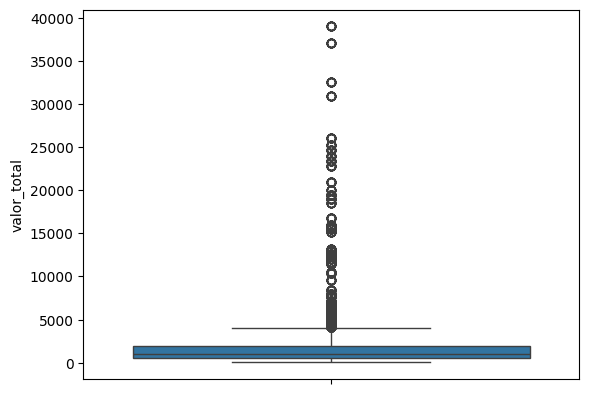

In [ ]:
sns.boxplot(df_itens_pedidos.valor_total)

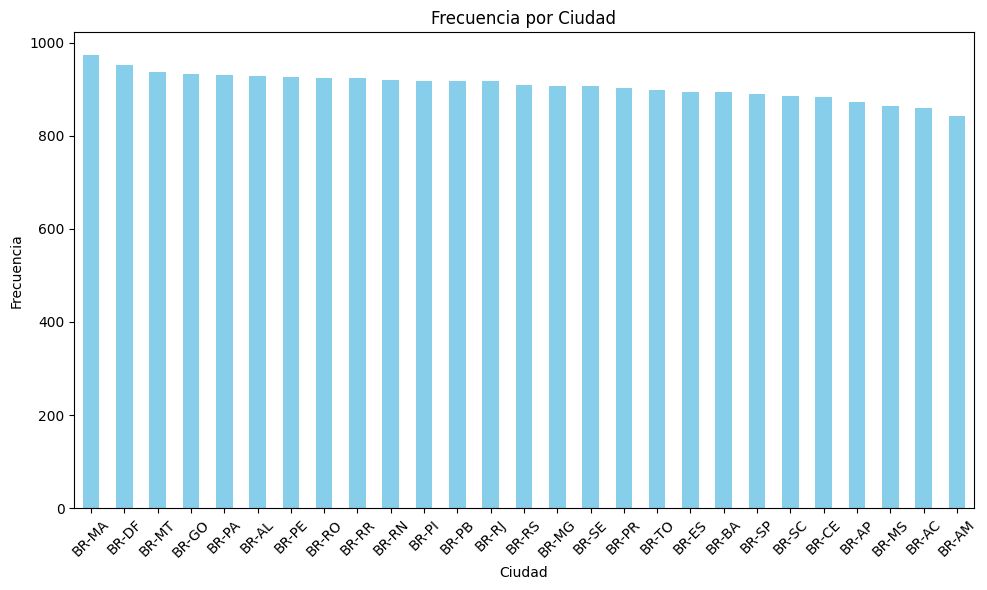

In [ ]:
#histograma de frecuencia de ciudad

# Calcular la frecuencia de cada ciudad con value_counts
frecuencia_ciudad = df_itens_pedidos['ciudad'].value_counts()

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
frecuencia_ciudad.plot(kind='bar', color='skyblue')

# Configurar título y etiquetas de los ejes
plt.title('Frecuencia por Ciudad')
plt.xlabel('Ciudad')
plt.ylabel('Frecuencia')

# Rotar las etiquetas del eje x para mejorar la legibilidad
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

In [ ]:
#valores unicos de la columna ciudades
ciudades = df_itens_pedidos['ciudad'].unique()
ciudades

array(['BR-BA', 'BR-RJ', 'BR-PB', 'BR-DF', 'BR-MG', 'BR-PR', 'BR-MS',
       'BR-SP', 'BR-GO', 'BR-AM', 'BR-CE', 'BR-RS', 'BR-AC', 'BR-RO',
       'BR-MT', 'BR-RR', 'BR-PE', 'BR-MA', 'BR-PA', 'BR-SC', 'BR-SE',
       'BR-TO', 'BR-AP', 'BR-PI', 'BR-ES', 'BR-AL', 'BR-RN'], dtype=object)

In [ ]:
ciudades_frecuencia = len(ciudades)
ciudades_frecuencia

27

In [ ]:
df_pedidos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24527 entries, 0 to 24526
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   pedido_id     24527 non-null  int64         
 1   producto_id   24527 non-null  int64         
 2   vendedor_id   24527 non-null  int64         
 3   fecha_compra  24527 non-null  datetime64[ns]
 4   total         24527 non-null  int64         
dtypes: datetime64[ns](1), int64(4)
memory usage: 958.2 KB


In [ ]:
df_pedidos.describe()

,pedido_id,producto_id,vendedor_id,fecha_compra,total
count,24527.000000,24527.000000,24527.000000,24527,24527.000000
mean,69931.383088,44627.641171,2.975782,2020-04-02 12:10:46.406001664,1867.490113
min,1.000000,2706.000000,1.000000,2019-01-05 00:00:00,45.000000
25%,34487.000000,17258.000000,2.000000,2019-11-12 00:00:00,520.000000
50%,69945.000000,42913.000000,3.000000,2020-04-09 00:00:00,1050.000000
75%,105355.000000,70673.000000,4.000000,2020-09-21 00:00:00,1920.000000
max,139993.000000,100983.000000,6.000000,2021-03-10 00:00:00,39000.000000
std,40560.769565,29347.824879,1.442412,NaN,3379.681887


<Axes: ylabel='total'>

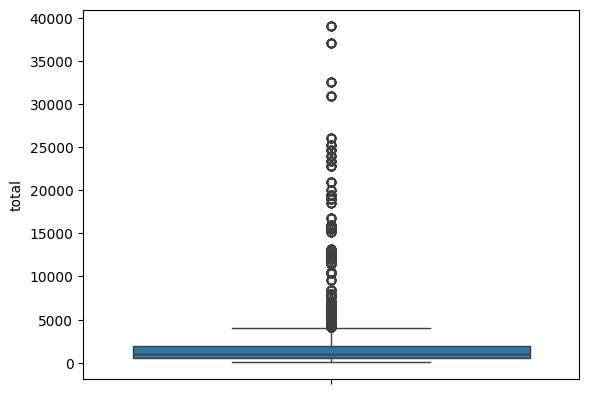

In [ ]:
sns.boxplot(df_pedidos.total)

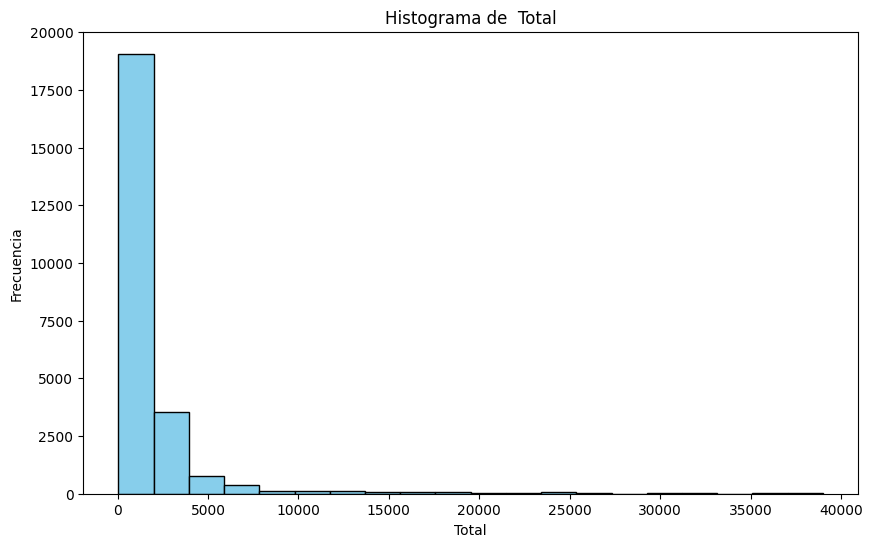

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df_pedidos['total'], bins=20, color='skyblue', edgecolor='black')

# Configurar título y etiquetas de los ejes
plt.title('Histograma de  Total')
plt.xlabel('Total')
plt.ylabel('Frecuencia')

# Mostrar el histograma
plt.show()

In [ ]:
#veremos las ventas diarias
ventas_diarias = df_pedidos.groupby(df_pedidos['fecha_compra'].dt.date)['total'].sum()
ventas_diarias

fecha_compra
2019-01-05    40576
2019-01-06     2160
2019-01-07     1950
2019-01-08     1280
2019-01-09      500
              ...  
2021-02-21    38681
2021-03-07     5930
2021-03-08    20258
2021-03-09     5160
2021-03-10    20177
Name: total, Length: 780, dtype: int64

In [ ]:
#quiero ver cuántas veces se repite el vendedor_id asi podre saber cuántas
#ventas ha hecho cada vendedor
ventas_por_vendedor = df_pedidos['vendedor_id'].value_counts()
ventas_por_vendedor

vendedor_id
5    5282
1    5167
2    5032
3    4840
4    4205
6       1
Name: count, dtype: int64

In [ ]:
#ahora quiero ver el registro de ese vendednor 6, q es desconocido y solo ha
#hecho 1 venta
registro_vendedor_6 = df_pedidos[df_pedidos['vendedor_id'] == 6]
registro_vendedor_6

,pedido_id,producto_id,vendedor_id,fecha_compra,total
0,341,41518,6,2019-01-05,780


In [ ]:
#bien en la tabla productos buscaremos el producto_id para saber ué producto
#es el que ha vendido el cliente y darle asi un reporte completo al cliente

In [ ]:
df_productos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 205 entries, 0 to 204
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   producto_id  205 non-null    int64  
 1   producto     205 non-null    object 
 2   precio       205 non-null    int64  
 3   marca        205 non-null    object 
 4   sku          205 non-null    float64
 5   condicion    205 non-null    object 
dtypes: float64(1), int64(2), object(3)
memory usage: 11.2+ KB


In [ ]:
df_productos.describe()

,producto_id,precio,sku
count,205.000000,205.000000,205.000000
mean,44803.365854,536.009756,304625.234146
std,29419.632374,843.774387,190141.444036
min,2706.000000,45.000000,101494.000000
25%,17329.000000,210.000000,222028.000000
50%,43054.000000,336.000000,263899.000000
75%,70673.000000,450.000000,304828.000000
max,100983.000000,6500.000000,952821.000000


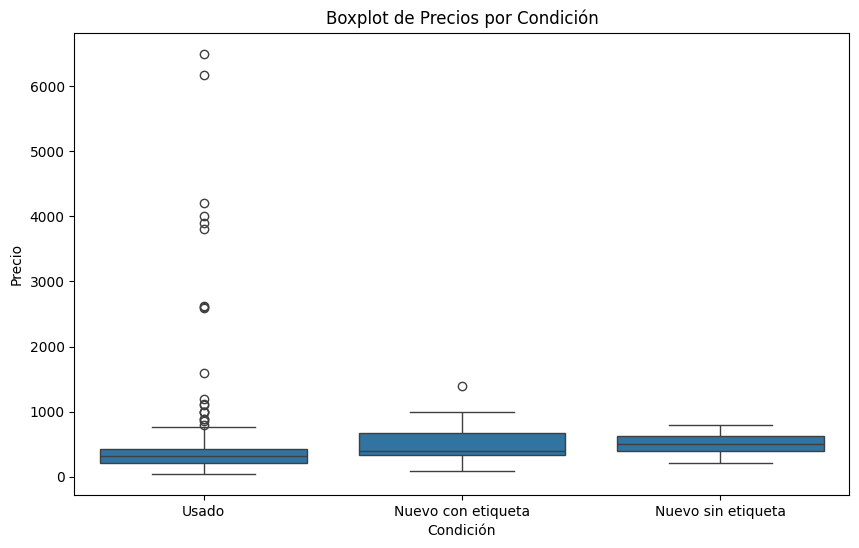

In [ ]:

#boxplot de relación concicion y precio de productos
# Crear el boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='condicion', y='precio', data=df_productos)

# Configurar título y etiquetas de los ejes
plt.title('Boxplot de Precios por Condición')
plt.xlabel('Condición')
plt.ylabel('Precio')

# Mostrar el boxplot
plt.show()

In [ ]:
producto_de_vendedor_6 = df_productos[df_productos['producto_id'] == 41518]
producto_de_vendedor_6

,producto_id,producto,precio,marca,sku,condicion
204,41518,Calca Jeans Basica,260,Banana Republic,255410.0,Nuevo con etiqueta


In [ ]:
#aqui quiero ver en el registro del pedido 341 que hizo el vendedor 6 segun mi
#df_itens_pedido asi podre saber cuántas cantidades vendio par un reporte completo
#de esta venta
cantidad_venta_vendedor6 = df_itens_pedidos[df_itens_pedidos['pedido_id'] == 341]
cantidad_venta_vendedor6

,id_recibo,producto_id,pedido_id,cantidad,valor_unitario,valor_total,ciudad,costo_envio
0,1,41518,341,3,260,780,BR-BA,156.0


In [ ]:
#ahora en la variable marcas guardare los valores unicos de las marcas
marcas = df_productos['marca'].unique()
marcas

array(['D&g Dolce & Gabbana', 'Givenchy', 'Joe Fresh', 'Mixed', 'Zara',
       'Gap', 'Banana Republic', 'Fyi', 'Sacada', 'Rag & Bone', 'Cori',
       'Forever 21', 'Tigresse', 'Tory Burch', 'Brooksfield', 'Animale',
       '284', 'Dkny', 'Cheroy', 'Canal', 'Le Lis Blanc', 'Spezzato',
       'Cantão', 'Talie Nk', 'H&M', 'Schutz', 'Jorge Bischoff',
       'Luisa Farani', 'Seven', 'Kipling', 'Louis Vuitton', 'Agilità',
       'Fabiana Caterina', 'Reinaldo Lourenço', 'Karmani', 'Erre Erre',
       'H&m', 'Forum', 'Ellus', 'J. Crew', "Joe's", 'Galeria Tricot',
       'Loft 747', 'Oxyfit', 'Topshop', 'A.brand', 'Isolda',
       'American Eagle', 'Colcci', 'Carter’s', 'Thay Ribas',
       'Carina Duek', 'Kate Spade', 'Bottega Veneta', 'Morena Rosa',
       'Luiza Barcelos', 'Lezalez', 'My Place', 'Farm', 'Armani Exchange',
       'Bcbgmaxzria', 'Dica da Ka', 'My Shoes', 'Argentum',
       'Red Valentino', 'Maria Filó', 'Marc By Marcjacobs',
       'Track & Field', 'Christian Dior', 'Toca do 

In [ ]:
#ahora en total_marcas_unicas con len veremos la
#cantidad de marcas que hay
total_marcas_unicas = len(marcas)
total_marcas_unicas

117

In [ ]:
productos_unicos = df_productos['producto'].unique()
total_productos_unicos = len(productos_unicos)
total_productos_unicos

201

In [ ]:
df_vendedores.describe()

,vendedor_id
count,6.000000
mean,3.500000
std,1.870829
min,1.000000
25%,2.250000
50%,3.500000
75%,4.750000
max,6.000000


In [ ]:
df_vendedores['vendedor_id'].unique()

array([1, 2, 3, 4, 5, 6])

In [ ]:
df_vendedores['nombre_vendedor'].unique()

array(['Ana Duarte', 'Daniel Siqueira', 'Nadia Oliveira',
       'Millena Pereira', 'Paulo Calanca', 'Unknown'], dtype=object)

In [ ]:
#Eliminando vendedor que no existe
df_vendedores.drop([5], axis=0, inplace=True)

df_vendedores['nombre_vendedor'].unique()

array(['Ana Duarte', 'Daniel Siqueira', 'Nadia Oliveira',
       'Millena Pereira', 'Paulo Calanca'], dtype=object)

#Crear banco de Datos

In [ ]:
def crear_conexion():
  global df_itens_pedidos, df_pedidos, df_productos, df_vendedores, database

  engine = create_engine('sqlite:///:memory:')
  database = engine

  df_itens_pedidos.to_sql('itens_pedidos', con=database)
  df_pedidos.to_sql('pedidos', con=database)
  df_productos.to_sql('productos', con=database)
  df_vendedores.to_sql('vendedores', con=database)


  inspector = inspect(database)
  print('Columnas de Tabla Itens_Pedidos:')
  for column in inspector.get_columns('itens_pedidos'):
      print(column)
      print('\n Columnas de Tabla Pedidos:')
  for column in inspector.get_columns('pedidos'):
      print(column)
      print('\n Columnas de Tabla Productos:')
  for column in inspector.get_columns('productos'):
      print(column)
      print('\n Columnas de Tabla Vendedores:')
  for column in inspector.get_columns('vendedores'):
      print(column)
     #database.dispose()

crear_conexion()


Columnas de Tabla Itens_Pedidos:
{'name': 'index', 'type': BIGINT(), 'nullable': True, 'default': None, 'primary_key': 0}

 Columnas de Tabla Pedidos:
{'name': 'id_recibo', 'type': BIGINT(), 'nullable': True, 'default': None, 'primary_key': 0}

 Columnas de Tabla Pedidos:
{'name': 'producto_id', 'type': BIGINT(), 'nullable': True, 'default': None, 'primary_key': 0}

 Columnas de Tabla Pedidos:
{'name': 'pedido_id', 'type': BIGINT(), 'nullable': True, 'default': None, 'primary_key': 0}

 Columnas de Tabla Pedidos:
{'name': 'cantidad', 'type': BIGINT(), 'nullable': True, 'default': None, 'primary_key': 0}

 Columnas de Tabla Pedidos:
{'name': 'valor_unitario', 'type': BIGINT(), 'nullable': True, 'default': None, 'primary_key': 0}

 Columnas de Tabla Pedidos:
{'name': 'valor_total', 'type': BIGINT(), 'nullable': True, 'default': None, 'primary_key': 0}

 Columnas de Tabla Pedidos:
{'name': 'ciudad', 'type': TEXT(), 'nullable': True, 'default': None, 'primary_key': 0}

 Columnas de Tabla P

In [ ]:
#verificamos el tipo de datos de las tablas
# Inspeccionar las tablas en la base de datos
inspector = inspect(database)

# Obtener el nombre de todas las tablas
tablas = inspector.get_table_names()

# Iterar sobre las tablas y mostrar la información sobre las columnas
for tabla in tablas:
    print(f"Tabla: {tabla}")
    columnas = inspector.get_columns(tabla)
    for columna in columnas:
        print(f" - {columna['name']}: {columna['type']}")

Tabla: itens_pedidos
 - index: BIGINT
 - id_recibo: BIGINT
 - producto_id: BIGINT
 - pedido_id: BIGINT
 - cantidad: BIGINT
 - valor_unitario: BIGINT
 - valor_total: BIGINT
 - ciudad: TEXT
 - costo_envio: FLOAT
Tabla: pedidos
 - index: BIGINT
 - pedido_id: BIGINT
 - producto_id: BIGINT
 - vendedor_id: BIGINT
 - fecha_compra: DATETIME
 - total: BIGINT
Tabla: productos
 - index: BIGINT
 - producto_id: BIGINT
 - producto: TEXT
 - precio: BIGINT
 - marca: TEXT
 - sku: FLOAT
 - condicion: TEXT
Tabla: vendedores
 - index: BIGINT
 - vendedor_id: BIGINT
 - nombre_vendedor: TEXT


In [ ]:
tab_product = pd.read_sql('SELECT * FROM productos', database)
tab_product

,index,producto_id,producto,precio,marca,sku,condicion
0,0,21244,Oculos Lente Azulada,1120,D&g Dolce & Gabbana,209297.0,Usado
1,1,9981,Bolsa Coral Saco,4000,Givenchy,278612.0,Usado
2,2,84176,Camisa Xadrez Verde,310,Joe Fresh,322482.0,Usado
3,3,47475,Calca Alfaiataria Preta,490,Mixed,263658.0,Usado
4,4,74864,Vestido Jeans Babados,130,Zara,219248.0,Usado
...,...,...,...,...,...,...,...
200,200,14074,Camisa Amarela Laco,450,Carol Bassi,309858.0,Usado
201,201,33349,Vestido Listras Malha,270,Calvin Klein,307118.0,Usado
202,202,22568,Casaqueto Estampa Geometrica,245,Zara,244931.0,Usado
203,203,40508,Regata Bicolor Alcinha,245,Express,247166.0,Usado


In [ ]:
tab_itens_pedidos = pd.read_sql('SELECT * FROM itens_pedidos', database)
tab_itens_pedidos

,index,id_recibo,producto_id,pedido_id,cantidad,valor_unitario,valor_total,ciudad,costo_envio
0,0,1,41518,341,3,260,780,BR-BA,156.0
1,1,2,4307,1174,5,6175,30875,BR-RJ,6175.0
2,2,3,22407,1399,3,200,600,BR-PB,120.0
3,3,4,3820,1652,6,139,834,BR-DF,166.8
4,4,5,29012,2470,3,525,1575,BR-BA,315.0
...,...,...,...,...,...,...,...,...,...
24522,24522,25051,64127,63716,4,590,2360,BR-PE,472.0
24523,24523,25052,37384,63999,4,700,2800,BR-RO,560.0
24524,24524,25053,100932,64594,5,3900,19500,BR-RO,3900.0
24525,24525,25054,3820,64811,3,139,417,BR-MA,83.4


In [ ]:
tab_pedidos = pd.read_sql('SELECT * FROM pedidos', database)
tab_pedidos

,index,pedido_id,producto_id,vendedor_id,fecha_compra,total
0,0,341,41518,6,2019-01-05 00:00:00.000000,780
1,1,1174,4307,3,2019-01-05 00:00:00.000000,30875
2,2,1399,22407,1,2019-01-05 00:00:00.000000,600
3,3,1652,3820,4,2019-01-05 00:00:00.000000,834
4,4,2470,29012,2,2019-01-05 00:00:00.000000,1575
...,...,...,...,...,...,...
24522,24522,63716,64127,1,2021-03-09 00:00:00.000000,2360
24523,24523,63999,37384,2,2021-03-09 00:00:00.000000,2800
24524,24524,64594,100932,1,2021-03-10 00:00:00.000000,19500
24525,24525,64811,3820,3,2021-03-10 00:00:00.000000,417


In [ ]:
tab_vendedores = pd.read_sql('SELECT * FROM vendedores', database)
tab_vendedores

,index,vendedor_id,nombre_vendedor
0,0,1,Ana Duarte
1,1,2,Daniel Siqueira
2,2,3,Nadia Oliveira
3,3,4,Millena Pereira
4,4,5,Paulo Calanca


#Pregunta 1
#¿Cual es el Top 5 productos más vendidos históricamente?

In [ ]:
''' para saber cuál ha sido el producto mas vendido
Crearemos una query SQL para cruzar las tablas productos e itens_pedidos,
agrupar por producto_id y totalizar la columna cantidad, ejecutar la query
en el banco database y guarda el resultado en el dataframe df.y
tambien obtendremos el total vendido multiplicando el valor uniitario
del producto por la cantidad vendida
'''
#primero la query
query = ('''
        SELECT p.producto_id, p.producto, SUM(i.cantidad) as total_cantidad,
        SUM(i.cantidad * i.valor_unitario) as total_valor_vendido
        FROM productos p
        INNER JOIN itens_pedidos i ON p.producto_id = i.producto_id
        GROUP BY p.producto_id, p.producto
        ORDER BY total_cantidad DESC
        LIMIT 5
        ''')


#ahora adicionamos la query a nuestro motor
df =pd.read_sql(sql = text(query), con=database.connect())
df

,producto_id,producto,total_cantidad,total_valor_vendido
0,32126,Saia Midi Cinto,549,115290
1,13814,Vestido Nude Reta,547,300850
2,47405,Blusa Manga Estampa,536,166160
3,33976,Camisa Xadrez Azul,511,61320
4,53941,Cropped Escritas Pb,508,142240


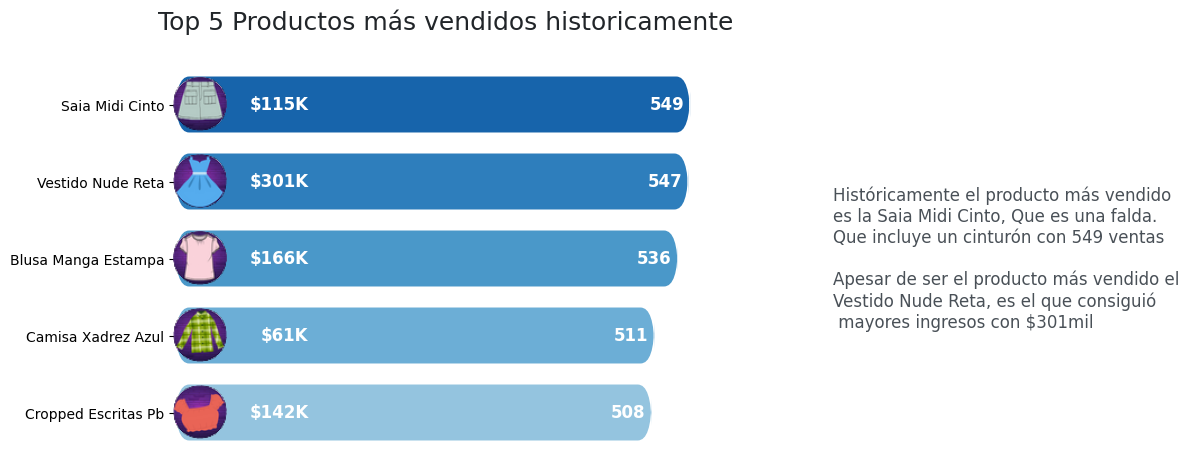

In [ ]:
df['total_valor_vendido'] = (df['total_valor_vendido']/1000).apply(lambda x: f'${x:.0f}K')
image_path = [
    'https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/imagenes/falda.png',
    'https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/imagenes/vestido.png',
    'https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/imagenes/blusa.png',
    'https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/imagenes/camisa.png',
    'https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/imagenes/cropped.png']

plt.subplots(figsize=(7, 5))
colores_azules = plt.cm.Blues_r(np.linspace(0.2,0.6,len(df)))
ax = sns.barplot(x=df.total_cantidad/20, y=df.producto, orient='h', joinstyle='bevel')

new_patches = []
for patch, color, producto, total_cantidad, total_valor_vendido, image_path in zip(ax.patches, colores_azules, df['producto'],df['total_cantidad'],df['total_valor_vendido'],image_path):
    bb = patch.get_bbox()
    p_bbox = FancyBboxPatch((bb.xmin, bb.ymin),
                            abs(bb.width), abs(bb.height),
                            boxstyle="round,pad=-0.05,rounding_size=0.73",
                            ec="none", fc=color,
                            mutation_aspect=0.73
                            )
    patch.remove()
    new_patches.append(p_bbox)

    #Añadir imagen dentro de la barra
    response = requests.get(image_path)
    image = plt.imread(BytesIO(response.content))
    imagebox = OffsetImage(image, zoom=0.8)
    ab = AnnotationBbox(imagebox, xy=(1.35, patch.get_y() + patch.get_height()/2),
                        xybox=(0, 0), xycoords='data', boxcoords="offset points",
                        pad=0, arrowprops=dict(arrowstyle='-', color='none'),
                        bboxprops=dict(facecolor='none',edgecolor='none'))
    ax.add_artist(ab)

    # Añadir texto (cantidad_vendida) al lado derecho de la barra
    ax.annotate(f'{total_cantidad}', xy=(patch.get_width(), patch.get_y() + patch.get_height ()/2),
    xytext=(-5, 0), textcoords='offset points',
    arrowprops=dict (arrowstyle='-', color='none'),
    color='white', fontweight='bold', fontsize=12, ha='right', va='center',
    xycoords='data',
    bbox=dict (facecolor='none', edgecolor='none', pad=0),
    annotation_clip=False)

    # Añadir texto (total_vendido) al lado izquierdo de la barra
    ax.annotate(f'{total_valor_vendido}', xy=(7.5, patch.get_y() + patch.get_height ()/2),
    xytext=(-5, 0), textcoords='offset points',
    arrowprops=dict(arrowstyle='-', color='none'),
    color='white', fontweight='bold', fontsize=12, ha='right', va='center',
    xycoords='data',
    bbox=dict (facecolor='none', edgecolor='none', pad=0),
    annotation_clip=False)

for patch in new_patches:
    ax.add_patch (patch)

conclusion_text=(
    "Históricamente el producto más vendido\n"
    "es la Saia Midi Cinto, Que es una falda.\n"
    "Que incluye un cinturón con 549 ventas\n\n"
    "Apesar de ser el producto más vendido el \n"
   "Vestido Nude Reta, es el que consiguió\n"
    " mayores ingresos con $301mil "
)

ax. text(35, 2, conclusion_text, fontsize=12, color='#495057', va= 'center', ha='left')

# Personalizando el gráfico
ax.set_title('Top 5 Productos más vendidos historicamente\n', loc='center', fontsize=18, color='#212529')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks([])
ax.yaxis.grid(False)
ax.xaxis.grid (False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

In [ ]:
#bien ahora quiero ver de qué marca es el producto más vendido
query = "SELECT * FROM productos WHERE producto = 'Saia Midi Cinto';"
pd.read_sql(sql = text(query), con=database.connect())


,index,producto_id,producto,precio,marca,sku,condicion
0,183,32126,Saia Midi Cinto,210,Limone By Jade Seba,302628.0,Nuevo sin etiqueta


In [ ]:
query = "SELECT * FROM productos WHERE producto = 'Vestido Nude Reta';"
pd.read_sql(sql = text(query), con=database.connect())

,index,producto_id,producto,precio,marca,sku,condicion
0,56,13814,Vestido Nude Reta,550,Ellus,318626.0,Nuevo sin etiqueta


Como vemos el producto mas vendido es la falda Saia Midi cinto de la marca Limone By Jade Seba y el producto que mayor ingreso aportó es el Vestido Nude Reta de la marca Ellus.

#2.¿Cual es la evolución histórica de las ingresos netos?

In [ ]:
'''Crea una query SQL para cruzar las tablas pedidos e itens_pedidos, agrupar
por fecha_compra y totalizar la resta de las columnas total - costo_envio,
ejecutar la query en el banco database y guarda el resultado en el dataframe df.
Verifica si la columna fecha_compra en el dataframe df tiene el tipo de dato
 correcto, sino, debes convertirlo a datetime.'''

 #primero la query
query = ('''
        SELECT fecha_compra, SUM(total - costo_envio) as valor_neto
        FROM pedidos
        INNER JOIN itens_pedidos  ON pedidos.pedido_id = itens_pedidos.pedido_id
        GROUP BY fecha_compra
        ''')


#ahora adicionamos la query a nuestro motor
#df =pd.read_sql(sql = text(query), con=database.connect())
#df
#otro método para leer la bd, convertir el tipo de la columna después de ejecutar la consulta query
df = pd.read_sql_query(query, database)
#Verificar y convertir el tipo de dato de la columna fecha_compra
if df['fecha_compra'].dtype != 'datetime64[ns]':
    df['fecha_compra'] = pd.to_datetime(df['fecha_compra'])

df

,fecha_compra,valor_neto
0,2019-01-05,32460.8
1,2019-01-06,1728.0
2,2019-01-07,1560.0
3,2019-01-08,1024.0
4,2019-01-09,400.0
...,...,...
775,2021-02-21,30944.8
776,2021-03-07,4744.0
777,2021-03-08,16206.4
778,2021-03-09,4128.0


In [ ]:
print(df.dtypes)


fecha_compra    datetime64[ns]
valor_neto             float64
dtype: object


In [ ]:
query = "SELECT * FROM productos WHERE producto = 'Vestido Nude Reta';"
pd.read_sql(sql = text(query), con=database.connect())

,index,producto_id,producto,precio,marca,sku,condicion
0,56,13814,Vestido Nude Reta,550,Ellus,318626.0,Nuevo sin etiqueta


In [ ]:
#ahora las marcas más vendidas para ello cruzaremos las tablas productos y pedidos


 #primero la query
query = ('''
        SELECT p.marca, SUM(i.cantidad) as cantidad_vendida
        FROM productos p
        INNER JOIN itens_pedidos i ON p.producto_id = i.producto_id
        GROUP BY p.marca
        ORDER BY cantidad_vendida DESC
        ''')


#ahora adicionamos la query a nuestro motor
df_marcas =pd.read_sql(sql = text(query), con=database.connect())
df_marcas

,marca,cantidad_vendida
0,Zara,9545
1,Mixed,5748
2,Animale,4013
3,Le Lis Blanc,2479
4,Banana Republic,2045
...,...,...
112,All Saints Spitalfields,349
113,Express,342
114,Bcbgmaxzria,333
115,Talie Nk,325


In [ ]:
#calcularemos el porcentaje vendido de cada marca y redondeamos

# Calcular el total de la columna cantidad_vendida
total_vendido = df_marcas['cantidad_vendida'].sum()

# Calcular el porcentaje para cada fila
df_marcas['porcentaje'] = ((df_marcas['cantidad_vendida'] / total_vendido) * 100).round(2)

# Mostrar el dataframe con la columna de porcentaje
df_marcas



,marca,cantidad_vendida,porcentaje
0,Zara,9545,11.13
1,Mixed,5748,6.70
2,Animale,4013,4.68
3,Le Lis Blanc,2479,2.89
4,Banana Republic,2045,2.38
...,...,...,...
112,All Saints Spitalfields,349,0.41
113,Express,342,0.40
114,Bcbgmaxzria,333,0.39
115,Talie Nk,325,0.38


In [ ]:
#ahora la suma del porcentaje del resto de marcas

# Tomar las cinco marcas más vendidas
top_5_marcas = df_marcas.head(5)

# Sumar las ventas de las marcas que no están en las cinco principales
resto_ventas = df_marcas[5:]['cantidad_vendida'].sum()

# Crear una nueva fila para representar la suma del resto de las marcas
fila_resto = pd.DataFrame([['Resto', resto_ventas, ((resto_ventas / total_vendido) * 100).round(2)]], columns=['marca', 'cantidad_vendida', 'porcentaje'])

# Concatenar la fila del resto al DataFrame top_5_marcas
top_5_marcas = pd.concat([top_5_marcas, fila_resto])

# Mostrar el DataFrame resultante
top_5_marcas

,marca,cantidad_vendida,porcentaje
0,Zara,9545,11.13
1,Mixed,5748,6.70
2,Animale,4013,4.68
3,Le Lis Blanc,2479,2.89
4,Banana Republic,2045,2.38
0,Resto,61944,72.22


In [ ]:
print(df_marcas.dtypes)


marca                object
cantidad_vendida      int64
porcentaje          float64
dtype: object


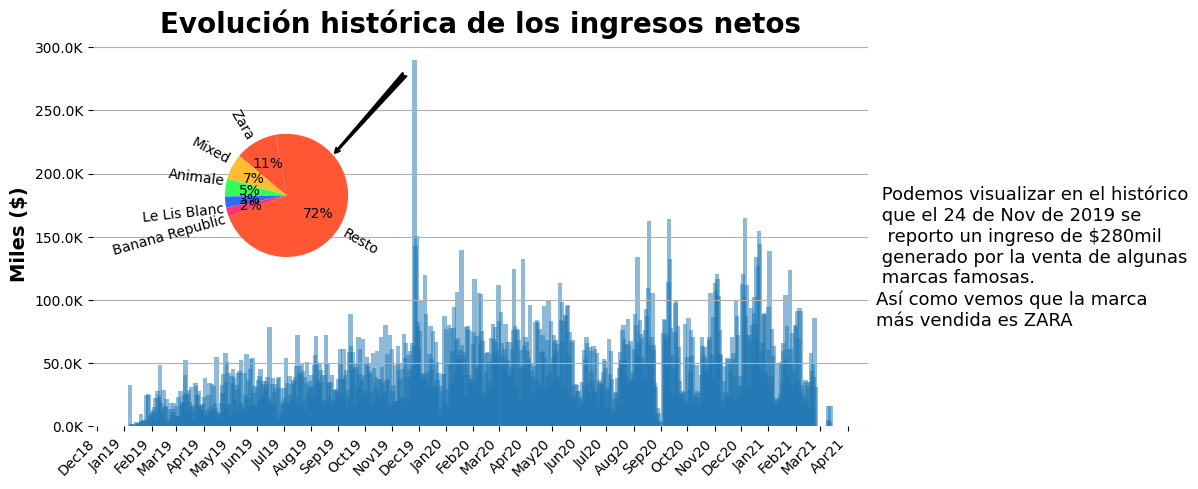

In [ ]:
                                   #creamos la gráfica y los ejes
fig, ax = plt.subplots(figsize=(10,5))
ax2 = ax.inset_axes([0.05, 0.4, 0.4, 0.4])


#Gráfico de barras
#Establecemos el ejeX como fecha en formato datetime
ejeX = df['fecha_compra']
ejeY = df['valor_neto']
barras = ax.bar(ejeX, ejeY, width=5, align='edge', alpha=0.5)

#formateo de ejes
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b' '%y'))
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:0.1f}K'.format(x/1000)))
ax.yaxis.set_ticks(range(0, int(max([10000, 50000, 200000, 300000])) + 1, 50000))
ax.set_title('Evolución histórica de los ingresos netos', fontsize=20, weight='bold')
ax.set_ylabel('Miles ($)', fontsize=14, weight='bold')
ax.grid(axis='y')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

#Datos para el gráfico de torta
colores_torta = ['#FF5733', '#FFBD33', '#33FF57', '#336BFF', '#FF336B']
ax2.pie(top_5_marcas['porcentaje'], labels=top_5_marcas['marca'], autopct="%1.0f%%",  startangle=100, colors=colores_torta, pctdistance=0.6, labeldistance=1.0, rotatelabels=True)

#Anotación y texto
ax2.annotate("", xy=(0.75, 0.65), xytext=(1.95, 2), ha='left', va='top', arrowprops=dict(arrowstyle='fancy', color='black'))
ax.text(187.5e2, 800e2, """ Podemos visualizar en el histórico\n que el 24 de Nov de 2019 se\n  reporto un ingreso de $280mil\n generado por la venta de algunas\n marcas famosas.\nAsí como vemos que la marca\nmás vendida es ZARA""",fontsize=13)

plt.xticks(rotation=45, ha='right')
plt.show()


In [ ]:
top_marcas = df_marcas.head()
top_marcas

,marca,cantidad_vendida,porcentaje
0,Zara,9545,11.13
1,Mixed,5748,6.70
2,Animale,4013,4.68
3,Le Lis Blanc,2479,2.89
4,Banana Republic,2045,2.38


(-0.5, 4.5)

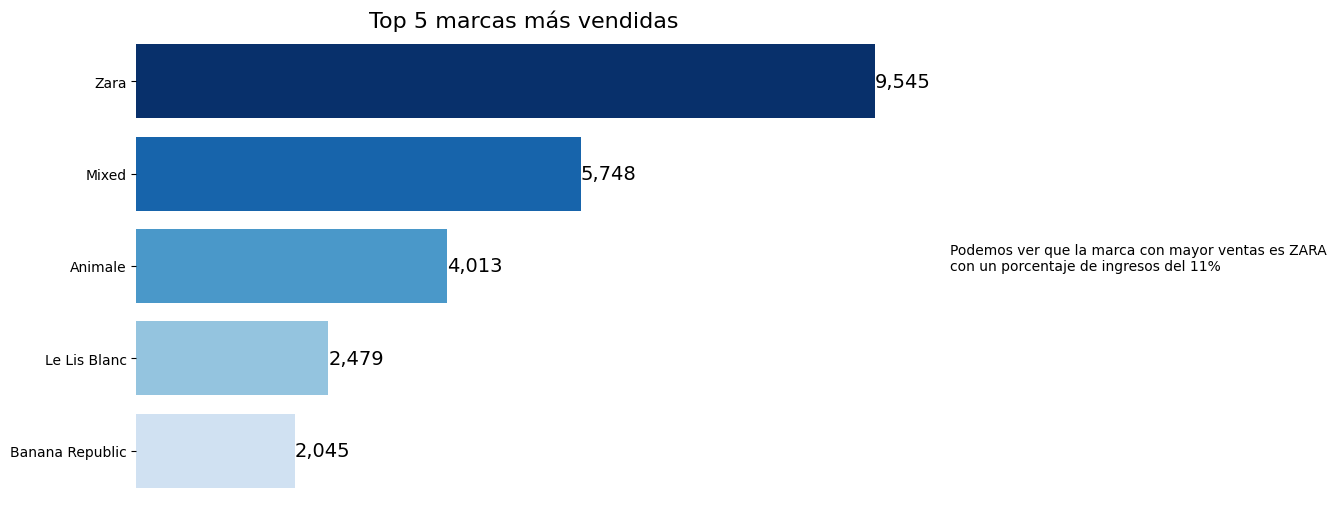

In [ ]:
# Poner las etiquetas y los datos a usar
labels = top_marcas['marca']
data = top_marcas['cantidad_vendida']
color_azul = 'blue'
colores = plt.cm.Blues(np.linspace(0.2, 1, len(labels)))

# Invertir el orden de los datos y las etiquetas
labels = labels[::-1]
data = data[::-1]


fig, ax = plt.subplots(figsize=(10,6))
ax.barh(labels, data, color=colores, align='center')


for i, valor in enumerate(data):
    qtd = "{:,.0f}".format(valor)  # Formatea el valor como texto sin el símbolo de peso y sin decimales
    ax.text(valor, i, qtd, ha='left', va='center', fontsize=14)

    # Oculta las líneas de los ejes
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().set_visible(False)

ax.set_title('Top 5 marcas más vendidas', fontsize=16)

descripcion = ("Podemos ver que la marca con mayor ventas es ZARA \n"
               "con un porcentaje de ingresos del 11% \n"
)

ax.text(1.05, 0.5, descripcion, transform=ax.transAxes, fontsize=10, va='center', ha='left', multialignment='left')

# Ajustar los límites del eje y para agregar margen
ax.set_ylim(-0.5, len(labels) - 0.5)


# 3) ¿Cuáles son los ingresos netos por vendedor por año?

In [ ]:
'''Crea una query SQL para cruzar las tablas pedidos, vendedores e itens_pedidos,
 agrupar por nombre_vendedor y crear 3 columnas totales, una por cada año,
 totalizando la resta de las columnas total - costo_envio, ejecutar la query en
 el banco database y guarda el resultado en el dataframe df.'''

''' haremo la query con SUM(sumaremos),  CASE WHEN(pondra la condicion),
 strftime('%Y', p.fecha_compra)-( formatear la fecha (fecha_compra de la tabla
  pedidos) en el formato del año ('%Y'). Devuelve el año como una cadena.)

 '''
 #primero la query
query = ('''SELECT v.nombre_vendedor,
            SUM(CASE WHEN strftime('%Y', p.fecha_compra) = '2019' THEN p.total - i.costo_envio ELSE 0 END) AS total_2019,
            SUM(CASE WHEN strftime('%Y', p.fecha_compra) = '2020' THEN p.total - i.costo_envio ELSE 0 END) AS total_2020,
            SUM(CASE WHEN strftime('%Y', p.fecha_compra) = '2021' THEN p.total - i.costo_envio ELSE 0 END) AS total_2021
            FROM pedidos p
            INNER JOIN vendedores v ON p.vendedor_id = v.vendedor_id
            INNER JOIN itens_pedidos i ON p.pedido_id = i.pedido_id
            GROUP BY v.nombre_vendedor;
        ''')

#ahora adicionamos la query a nuestro motor
df_ingresos_vendedores =pd.read_sql(sql = text(query), con=database.connect())
df_ingresos_vendedores

,nombre_vendedor,total_2019,total_2020,total_2021
0,Ana Duarte,2154261.6,5054009.6,547470.4
1,Daniel Siqueira,2020503.2,5266932.8,419702.4
2,Millena Pereira,2054682.4,3804385.6,398896.0
3,Nadia Oliveira,2296986.4,4046902.4,810020.0
4,Paulo Calanca,3702835.2,3609530.4,455401.6


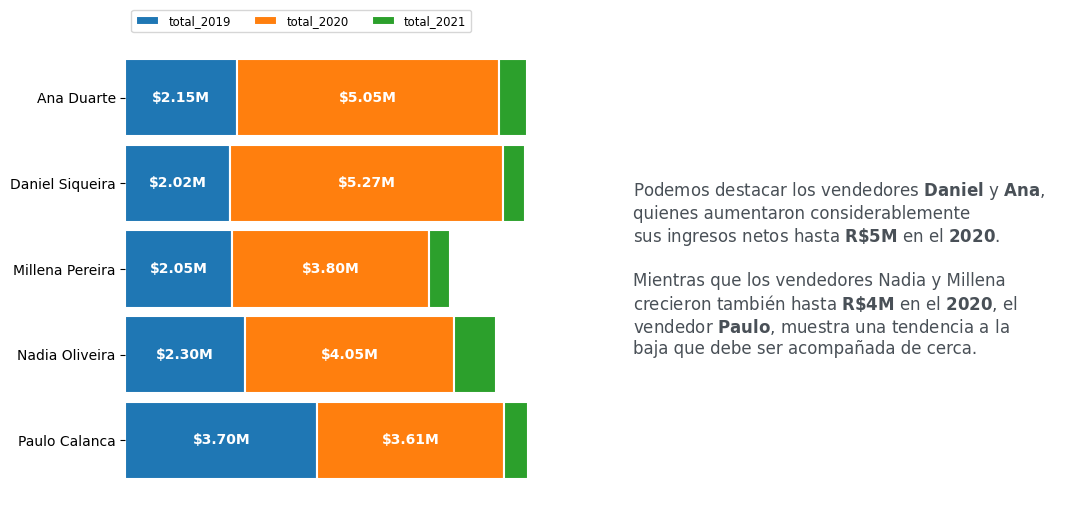

In [ ]:
#Visualización de la gráfica

#creamos una grafica con dos ax, donde ax1 sera  la grafica de barras apiladas,
#y ax2 sera nuestro texto
'''
Esta línea creara una figura que contiene dos subgráficos dispuestos en una fila
(1) y dos columnas (2). La opción gridspec_kw={'width_ratios': [1, 1]}
establece que ambas columnas tendrán el mismo ancho.
'''
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 1]}, figsize=(12, 6))
ax1.invert_yaxis() #invierte las etiquetas para q se muestren de ariba a abajo
ax1.xaxis.set_visible(False)  #oculta el eje X y sus valores

# Eliminar los bordes de la gráfica
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)

# Poner las etiquetas y los datos a usar
category_names = ['total_2019', 'total_2020', 'total_2021']
labels = df_ingresos_vendedores['nombre_vendedor']
data = df_ingresos_vendedores[category_names].values

for i, colname in enumerate(category_names):
    widths = data[:, i]
    starts = np.cumsum(data[:, :i], axis=1)[:, -1] if i > 0 else 0
    bars = ax1.barh(labels, widths, left=starts, height=0.9, edgecolor='white', linewidth=1.5, label=colname)

    for bar, c in zip(bars, data[:, i]):
       # Agregar texto solo para los años diferentes a 2021
      if colname != "total_2021":
            ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2,
                     f'${c / 1000000:.2f}M', ha='center', va='center', color='white', fontweight='bold')


ax1.legend(ncol=len(category_names), bbox_to_anchor=(0, 1), loc='lower left', fontsize='small')


# Agregar texto de conclusión en el subplot derecho
conclusion_text = (
    "Podemos destacar los vendedores $\\bf{Daniel}$ y $\\bf{Ana}$,\n"
    "quienes aumentaron considerablemente\n"
    "sus ingresos netos hasta $\\bf{R \\$5M}$ en el $\\bf{2020}$.\n\n"
    "Mientras que los vendedores Nadia y Millena\n"
    "crecieron también hasta $\\bf{R \\$4M}$ en el $\\bf{2020}$, el\n"
    "vendedor $\\bf{Paulo}$, muestra una tendencia a la\n"
    "baja que debe ser acompañada de cerca."
)

ax2.text(0, 0.5, conclusion_text, fontsize=12, color='#495057', va='center', ha='left')
ax2.axis('off')

plt.show()

# 4) ¿Cuáles son los ingresos netos por vendedor por año?

crea una query SQL para cruzar las tablas pedidos e itens_pedidos, agrupar por ciudad y totalizar la resta de las columnas total - costo_envio, ejecutar la query en el banco database y guarda el resultado en el dataframe df.

Puedes crear una nueva columna en df llamada abbrev_state retirando la palabra 'BR-' de la columna ciudad

In [ ]:
#Definir la consulta SQL
query = """
    SELECT ip.ciudad, SUM(ip.costo_envio) AS costos, SUM(p.total - ip.costo_envio) AS ingresos_netos
    FROM pedidos p
    INNER JOIN itens_pedidos ip ON p.pedido_id = ip.pedido_id
    GROUP BY ip.ciudad;
"""
#Ejecutar la consulta SQL y guardar el resultado en un DataFrame
df = pd.read_sql_query(text(query), database)
df['abbrev_state'] = df['ciudad'].apply(lambda x: x.replace('BR-', ''))
df.head()

,ciudad,costos,ingresos_netos,abbrev_state
0,BR-AC,282130.0,1128520.0,AC
1,BR-AL,380504.0,1522016.0,AL
2,BR-AM,311023.2,1244092.8,AM
3,BR-AP,368934.4,1475737.6,AP
4,BR-BA,330629.4,1322517.6,BA


In [ ]:
#Seleccionando ciudad e ingreso neto
df_ci = df[["ingresos_netos", "abbrev_state"]]
df_ci.head()

,ingresos_netos,abbrev_state
0,1128520.0,AC
1,1522016.0,AL
2,1244092.8,AM
3,1475737.6,AP
4,1322517.6,BA


Ahora, para obtener las geometrías o coordenadas geográficas de cada ciudad de Brasil, podemos usar la biblioteca geobr, invocando su método read_state() y luego hacer un merge con nuestro dataframe df para cruzar ambas bases y quedarnos únicamente con las columnas que necesitamos para el gráfico, guardamos este merge en un nuevo dataframe br_uf_d

In [ ]:
#aplicaremos el siguiente metodo para obtener los codigos de las ciudades
br_uf = geobr.read_state(code_state="all")
br_uf.head()

,code_state,abbrev_state,name_state,code_region,name_region,geometry
0,11.0,RO,Rondônia,1.0,Norte,"MULTIPOLYGON (((-63.32721 -7.97672, -62.86662 ..."
1,12.0,AC,Acre,1.0,Norte,"MULTIPOLYGON (((-73.18253 -7.33550, -72.58477 ..."
2,13.0,AM,Amazonas,1.0,Norte,"MULTIPOLYGON (((-67.32609 2.02971, -67.31682 2..."
3,14.0,RR,Roraima,1.0,Norte,"MULTIPOLYGON (((-60.20051 5.26434, -60.19273 5..."
4,15.0,PA,Pará,1.0,Norte,"MULTIPOLYGON (((-54.95431 2.58369, -54.93542 2..."


In [ ]:
#merge Geometría y nuestras ciudades
'''fusiona dos DataFrames, br_uf y df_ci, utilizando la columna "abbrev_state" como
 clave de unión tanto para el DataFrame izquierdo (br_uf) como para el derecho
(df_ci). El resultado de esta fusión se almacena en el DataFrame br_uf_d.'''
br_uf_d=pd.merge(br_uf, df_ci, left_on="abbrev_state", right_on="abbrev_state")
br_uf_d

,code_state,abbrev_state,name_state,code_region,name_region,geometry,ingresos_netos
0,11.0,RO,Rondônia,1.0,Norte,"MULTIPOLYGON (((-63.32721 -7.97672, -62.86662 ...",1317495.2
1,12.0,AC,Acre,1.0,Norte,"MULTIPOLYGON (((-73.18253 -7.33550, -72.58477 ...",1128520.0
2,13.0,AM,Amazonas,1.0,Norte,"MULTIPOLYGON (((-67.32609 2.02971, -67.31682 2...",1244092.8
3,14.0,RR,Roraima,1.0,Norte,"MULTIPOLYGON (((-60.20051 5.26434, -60.19273 5...",1349770.4
4,15.0,PA,Pará,1.0,Norte,"MULTIPOLYGON (((-54.95431 2.58369, -54.93542 2...",1345199.2
5,16.0,AP,Amapá,1.0,Norte,"MULTIPOLYGON (((-51.17970 4.00008, -51.17739 3...",1475737.6
6,17.0,TO,Tocantins,1.0,Norte,"MULTIPOLYGON (((-48.35878 -5.17008, -48.33846 ...",1284983.2
7,21.0,MA,Maranhão,2.0,Nordeste,"MULTIPOLYGON (((-45.84073 -1.04548, -45.84099 ...",1453059.2
8,22.0,PI,Piauí,2.0,Nordeste,"MULTIPOLYGON (((-41.74605 -2.80350, -41.73488 ...",1358606.4
9,23.0,CE,Ceará,2.0,Nordeste,"MULTIPOLYGON (((-41.16703 -4.46736, -41.17757 ...",1468080.8


In [ ]:
#seleccionando las columnas para el gráfico
br_uf_d=br_uf_d[["geometry","abbrev_state","ingresos_netos"]]
br_uf_d

,geometry,abbrev_state,ingresos_netos
0,"MULTIPOLYGON (((-63.32721 -7.97672, -62.86662 ...",RO,1317495.2
1,"MULTIPOLYGON (((-73.18253 -7.33550, -72.58477 ...",AC,1128520.0
2,"MULTIPOLYGON (((-67.32609 2.02971, -67.31682 2...",AM,1244092.8
3,"MULTIPOLYGON (((-60.20051 5.26434, -60.19273 5...",RR,1349770.4
4,"MULTIPOLYGON (((-54.95431 2.58369, -54.93542 2...",PA,1345199.2
5,"MULTIPOLYGON (((-51.17970 4.00008, -51.17739 3...",AP,1475737.6
6,"MULTIPOLYGON (((-48.35878 -5.17008, -48.33846 ...",TO,1284983.2
7,"MULTIPOLYGON (((-45.84073 -1.04548, -45.84099 ...",MA,1453059.2
8,"MULTIPOLYGON (((-41.74605 -2.80350, -41.73488 ...",PI,1358606.4
9,"MULTIPOLYGON (((-41.16703 -4.46736, -41.17757 ...",CE,1468080.8


In [ ]:
#verifico tipo de datos
print(br_uf_d["ingresos_netos"].dtype)

float64


Visualización:

Para crear un gráfico de mapa coroplético puedes usar lo siguiente: br_uf_d.plot(ax=ax,column="ingresos_netos",cmap="Blues")Donde:ax: Indica el eje en el que se debe trazar el gráfico.column: Indica qué columna del GeoDataFrame br_uf_d se utilizará para asignar colores a las ciudades en el mapa.cmap: Indica la paleta de colores que se utilizará para el mapa.

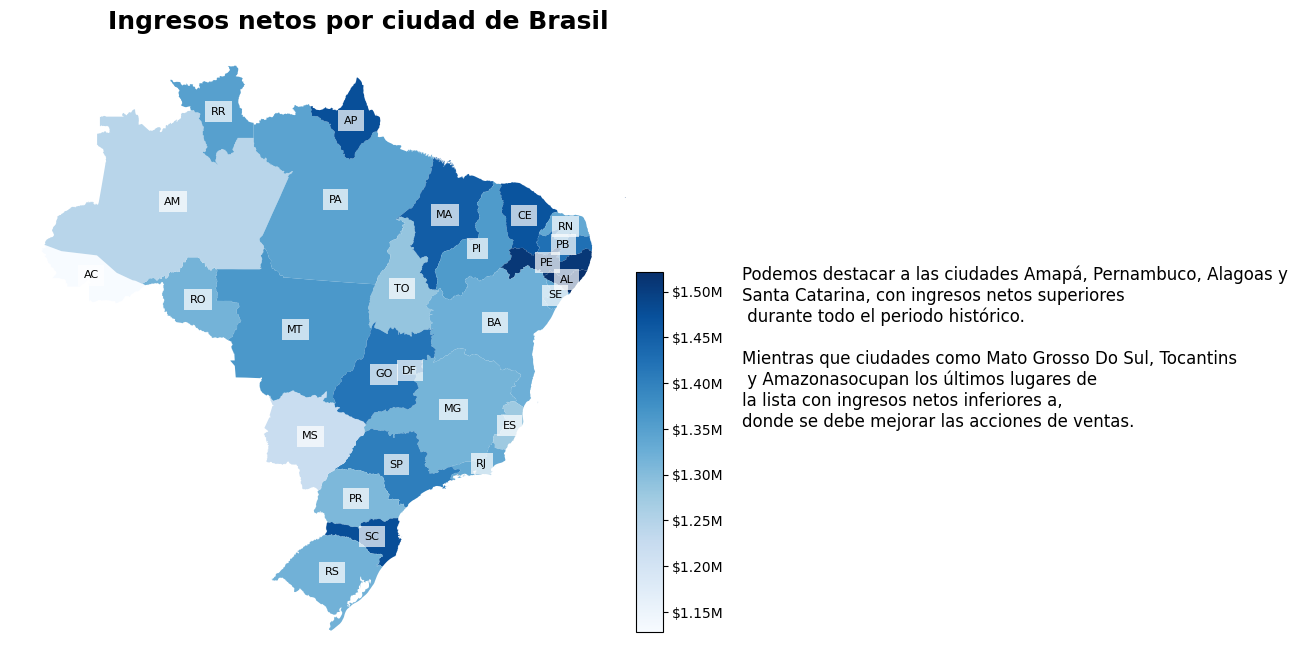

In [182]:
# Crear la figura y los objetos de ejes
fig, ax = plt.subplots(figsize=(9, 9))
ax=br_uf_d.plot(ax=ax,column="ingresos_netos",cmap="Blues")
cax = fig.add_axes([0.82, 0.18,0.03,0.40,])
sm = plt.cm.ScalarMappable(
    cmap="Blues",                                       # Usa o mesmo cmap do mapa
    norm=plt.Normalize(
        vmin=br_uf_d["ingresos_netos"].min(),  # Valor mínimo
        vmax=br_uf_d["ingresos_netos"].max(),  # Valor máximo
    ),
)

fig.colorbar( sm,
    cax=cax,
    # Formata a escala do Colorbar
    format=ticker.FuncFormatter(lambda x, _: f'${x / 1000000:.2f}M'),)

# Añadir nombres de ciudades
for idx, row in br_uf_d.iterrows():
    ax.annotate(row["abbrev_state"],
                (row["geometry"].centroid.x, row["geometry"].centroid.y),
                fontsize=8,
                ha='center',
                va='center',
                color='black',
                backgroundcolor='white',
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# Eliminar etiquetas y ticks del eje y
ax.set_xticklabels([])
ax.tick_params(axis='x', which='both', length=0)
ax.tick_params(axis='y', which='both', length=0)
ax.set_yticklabels([])
# Eliminar el título del eje x
ax.set_xlabel('')
# Eliminar el título del eje y
ax.set_ylabel('')
# Agregar espacio a la derecha del gráfico para el texto "lorem ipsum"
fig.subplots_adjust(right=0.9)  # Ajusta el valor según el espacio deseado

#AGREGA EL TITULO
ax.set_title("Ingresos netos por ciudad de Brasil",fontdict={"fontsize": 18},fontweight='bold')
# Obtener límites del eje x y eje y
x_limits = ax.get_xlim()
y_limits = ax.get_ylim()

conclusion_text=(
    "Podemos destacar a las ciudades Amapá, Pernambuco, Alagoas y \n"
    "Santa Catarina, con ingresos netos superiores\n"
    " durante todo el periodo histórico.\n\n"
    "Mientras que ciudades como Mato Grosso Do Sul, Tocantins  \n"
    " y Amazonasocupan los últimos lugares de\n"
    "la lista con ingresos netos inferiores a,\n"
    "donde se debe mejorar las acciones de ventas."
    )
# Añadir texto adicional debajo de la línea
ax.text(x_limits[1] + (x_limits[1] - x_limits[0]) * 0.05,
         (y_limits[0] + y_limits[1]) / 2,
         conclusion_text,
         fontsize=12,
         ha='left',  # Alinear a la izquierda horizontalmente
         va='center')  # Centrar verticalmente


# Quitar la cuadrícula del fondo
ax.grid(False)
# Quitar el cuadro delimitador
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.show()

# 5) ¿Existe otro insight que puedas proporcionar?

In [ ]:
tab_pedidos = pd.read_sql('SELECT * FROM pedidos', database)
tab_pedidos.head()

,index,pedido_id,producto_id,vendedor_id,fecha_compra,total
0,0,341,41518,6,2019-01-05 00:00:00.000000,780
1,1,1174,4307,3,2019-01-05 00:00:00.000000,30875
2,2,1399,22407,1,2019-01-05 00:00:00.000000,600
3,3,1652,3820,4,2019-01-05 00:00:00.000000,834
4,4,2470,29012,2,2019-01-05 00:00:00.000000,1575


In [ ]:
tab_itens_pedidos = pd.read_sql('SELECT * FROM itens_pedidos', database)
tab_itens_pedidos.head()

,index,id_recibo,producto_id,pedido_id,cantidad,valor_unitario,valor_total,ciudad,costo_envio
0,0,1,41518,341,3,260,780,BR-BA,156.0
1,1,2,4307,1174,5,6175,30875,BR-RJ,6175.0
2,2,3,22407,1399,3,200,600,BR-PB,120.0
3,3,4,3820,1652,6,139,834,BR-DF,166.8
4,4,5,29012,2470,3,525,1575,BR-BA,315.0


In [ ]:
query="""
      SELECT ip.ciudad, p.fecha_compra, SUM(p.total) AS ingresos_totales
      FROM itens_pedidos ip
      INNER JOIN pedidos p ON ip.pedido_id = p.pedido_id
      GROUP BY ip.ciudad, p.fecha_compra
      ORDER BY ingresos_totales DESC;
"""
#ahora adicionamos la query a nuestro motor
df_ingresos_totales =pd.read_sql(sql = text(query), con=database.connect())
df_ingresos_totales

,ciudad,fecha_compra,ingresos_totales
0,BR-AC,2021-02-02 00:00:00.000000,54850
1,BR-TO,2020-10-31 00:00:00.000000,53320
2,BR-RJ,2020-08-15 00:00:00.000000,50200
3,BR-RS,2021-01-23 00:00:00.000000,49794
4,BR-CE,2020-01-08 00:00:00.000000,48020
...,...,...,...
13485,BR-AM,2020-12-24 00:00:00.000000,45
13486,BR-AP,2020-01-15 00:00:00.000000,45
13487,BR-ES,2020-03-11 00:00:00.000000,45
13488,BR-PB,2019-09-16 00:00:00.000000,45


In [ ]:
df_ingresos_totales['fecha_compra'] = pd.to_datetime(df_ingresos_totales['fecha_compra'])
df_ingresos_totales['fecha_compra']

0       2021-02-02
1       2020-10-31
2       2020-08-15
3       2021-01-23
4       2020-01-08
           ...    
13485   2020-12-24
13486   2020-01-15
13487   2020-03-11
13488   2019-09-16
13489   2019-10-16
Name: fecha_compra, Length: 13490, dtype: datetime64[ns]

In [ ]:
# Obtener el año de la fecha de compra
df_ingresos_totales['año'] = df_ingresos_totales['fecha_compra'].dt.year
# Agrupar por ciudad y año, y sumar los ingresos totales
top_ciudades_por_año = df_ingresos_totales.groupby(['ciudad', 'año'])['ingresos_totales'].sum().reset_index()

# Obtener el top 5 de ciudades que más ingresos han generado por año
top_3_ciudades_por_año = top_ciudades_por_año.groupby('año').apply(lambda x: x.nlargest(3, 'ingresos_totales'))

top_3_ciudades_por_año


ciudad   año  ingresos_totales
año                                   
2019 75  BR-SP  2019            687387
     3   BR-AL  2019            651736
     9   BR-AP  2019            627884
2020 43  BR-PB  2020           1169099
     70  BR-SC  2020           1124886
     4   BR-AL  2020           1122698
2021 47  BR-PE  2021            195904
     20  BR-DF  2021            174550
     14  BR-BA  2021            166887

ValueError: 'año' is both an index level and a column label, which is ambiguous.

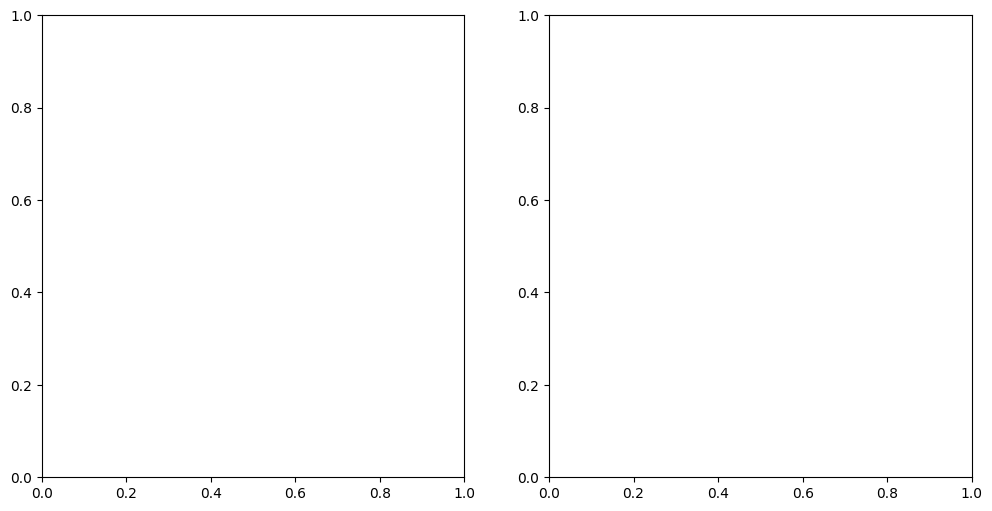

In [183]:
# Crear una figura y dos ejes
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Colores para diferenciar los años
colores = ['blue', 'orange', 'green', 'red', 'purple']

# Definir el ancho de las barras
bar_width = 0.2

# Lista para almacenar los artistas de las barras y sus etiquetas
handles, labels = [], []

# Iterar sobre cada año en el top 3 de ciudades por año
for i, (año, datos_año) in enumerate(top_3_ciudades_por_año.groupby('año')):
    # Definir la posición de las barras para este año
    posiciones = np.arange(len(datos_año['ciudad'])) + i * bar_width

    # Iterar sobre cada ciudad en el top 3 de ciudades de ese año
    for j, (ciudad, ingresos) in enumerate(zip(datos_año['ciudad'], datos_año['ingresos_totales'])):
        # Filtrar los datos solo para esta ciudad y este año
        datos_ciudad = df_ingresos_totales[(df_ingresos_totales['ciudad'] == ciudad) & (df_ingresos_totales['año'] == año)]
        # Calcular el total de ingresos para esta ciudad en este año
        total_ingresos = datos_ciudad['ingresos_totales'].sum()
        # Formatear el total de ingresos para mostrar en la barra
        if total_ingresos >= 1_000_000:
            qtd = "${:.2f}M".format(total_ingresos / 1_000_000)  # Formatear a millones
        elif total_ingresos >= 1_000:
            qtd = "${:.0f}K".format(total_ingresos / 1_000)      # Formatear a miles
        else:
            qtd = "${:.0f}".format(total_ingresos)               # Sin formateo

        # Graficar los ingresos de esta ciudad en este año como una barra
        bar = ax1.bar(posiciones[j], total_ingresos, width=bar_width, color=colores[i], label=f'{ciudad} ({año})')
        # Añadir el valor de ingresos totales formateado en la barra
        ax1.text(posiciones[j], total_ingresos, qtd, ha='center', va='bottom')  # Cambiar va a 'bottom'

        # Almacenar los artistas de las barras y sus etiquetas
        handles.append(bar)
        labels.append(f'{ciudad} ({año})')

# Oculta las líneas de los ejes en el primer eje
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
# Ajustar el margen izquierdo del primer eje
ax1.set_ylim(bottom=0.5)


# Añade el título al primer eje
ax1.set_title('Top 3 Ciudades con más ventas por Año', fontsize=16)

# Añadir leyenda en el segundo eje con los artistas y etiquetas almacenados
ax2.legend(handles, labels, loc='upper left')
# Ajustar el segundo eje para que solo muestre la leyenda sin ejes
ax2.axis('off')

# Ajustar el espaciado entre subplots
plt.tight_layout()

# Mostrar la gráfica
plt.show()